In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
from transformers import Wav2Vec2Model
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import av
import torchaudio
from pydub import AudioSegment
import random
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
import torch.nn.functional as F
from torchvision.models import resnet50
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup
from IPython.display import clear_output
import torchvision.models
from torchvision.models.video import r3d_18
import io
from torchvision.transforms import transforms

## Данные


0 - меньше ста тысяч просмотров, 1 - от ста до пятисот тысяч, 2 - от пятисот до милллиона, 3 - супер вирусный, от 1 милллиона

In [ ]:
def mm(x):
  if x<=100000:
    x = 0
  elif (x>100000) & (x<500000):
    x = 1
  elif (x>500000) & (x<1000000):
    x = 2
  else:
    x = 3
  return x

In [ ]:
dfik = pd.read_csv('full_df.csv')

In [ ]:
dfik['youtube_views'] =  dfik['youtube_views'].apply(lambda x: mm(x)  )

In [ ]:
dfik = dfik.iloc[:,:6]

In [ ]:
dfik

,Unnamed: 0.1,id,movie_title,trailer_path,youtube_views,youtube_likes
0,0,629,The Usual Suspects,trailers/The_Usual_Suspects_629.mp4,0,97.0
1,1,10160,A Nightmare on Elm Street 5: The Dream Child,trailers/A_Nightmare_on_Elm_Street_5__The_Drea...,1,1898.0
2,2,11452,National Lampoon’s Van Wilder,trailers/National_Lampoon_s_Van_Wilder_11452.mp4,3,0.0
3,3,12163,The Wrestler,trailers/The_Wrestler_12163.mp4,1,1348.0
4,4,32275,Duel in the Sun,trailers/Duel_in_the_Sun_32275.mp4,0,307.0
...,...,...,...,...,...,...
1819,1202,16619,Ordinary People,trailers/Ordinary_People_16619.mp4,0,44.0
1820,1203,1725,West Side Story,trailers/West_Side_Story_1725.mp4,1,650.0
1821,1204,11977,Caddyshack,trailers/Caddyshack_11977.mp4,0,152.0
1822,1205,20322,The Brothers,trailers/The_Brothers_20322.mp4,1,1253.0


## Датасет и Даталоадер

Датасет извлекат из всего видеоряда только некоторые куски,начиная с рандомного start_frame. Всего извлекается 60 кадров для каждого трейлера. Аудиоряд берется из соответсвуюещего куска видео с частотой 16000 Гц. Также кадры нормализуются в соотвествии с Imagenet.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class FastTrailerDataset(Dataset):
    def __init__(self, df, target_frames=60, clip_length=2.0, audio_rate=16000, transform=None):

        self.df = df
        self.target_frames = target_frames
        self.clip_length = clip_length
        self.audio_rate = audio_rate
        self.transform = transform
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def _load_audio_segment(self, video_path):
        """Быстрая загрузка аудио один раз для всего видео"""
        audio = AudioSegment.from_file(video_path)
        return audio.set_frame_rate(self.audio_rate).set_channels(1)

    def _extract_frames(self, cap, start_frame, fps):
        """Эффективное извлечение кадров"""
        frames = []
        for i in range(self.target_frames):
            frame_pos = start_frame + int(i * (fps * self.clip_length / self.target_frames))
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))
                frame = torch.from_numpy(frame).float() / 255.0
                frame = frame.permute(2, 0, 1)
                frame = self.normalize(frame)
                frames.append(frame)
            else:
                frames.append(torch.zeros((224, 224, 3), dtype=torch.float32))
        return torch.stack(frames, dim = 1)  # (T, C, H, W)

    def _extract_audio(self, audio_seg, start_sec):
        """Оптимизированное извлечение аудио"""
        start_ms = start_sec * 1000
        end_ms = start_ms + self.clip_length * 1000
        segment = audio_seg[start_ms:end_ms]

        # Быстрое преобразование в numpy array
        samples = np.array(segment.get_array_of_samples())
        samples = samples.astype(np.float32) / (2**15)  # Нормализация для int16

        # Обрезка/дополнение до нужной длины
        target_len = int(self.clip_length * self.audio_rate)
        if len(samples) < target_len:
            samples = np.pad(samples, (0, target_len - len(samples)))
        else:
            samples = samples[:target_len]

        return torch.from_numpy(samples).unsqueeze(0)  # (1, L)

    def __getitem__(self, idx):
        video_path = self.df.iloc[idx]['trailer_path']

        # 1. Загружаем аудио один раз для всего видео
        audio_seg = self._load_audio_segment(video_path)

        # 2. Открываем видео
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # 3. Выбираем случайный старт
        max_start_frame = max(0, total_frames - int(fps * self.clip_length))
        start_frame = random.randint(0, max_start_frame) if max_start_frame > 0 else 0
        start_sec = start_frame / fps

        # 4. Параллельно извлекаем кадры и аудио
        frames = self._extract_frames(cap, start_frame, fps)
        audio = self._extract_audio(audio_seg, start_sec)
        audio = audio.squeeze(0)
        cap.release()

        # 5. Применяем трансформации (если есть)
        if self.transform:
            frames = torch.stack([self.transform(f) for f in frames])
        return {
            'rgb': torch.FloatTensor(frames),
            'audio': audio,
            'views': torch.FloatTensor([self.df.iloc[idx]['youtube_views']]),
            'path': video_path
        }


    def __len__(self):
        return len(self.df)

Using device: cuda


Пропишем collate fn для даталоадера

In [ ]:
def custom_collate_fn(batch):
    # Отфильтровываем None (битые примеры)
    batch = [item for item in batch if item is not None]

    # Если весь батч состоит из None
    if len(batch) == 0:
        return None

    # Собираем батч для каждой модальности
    collated_batch = {
        'rgb': torch.stack([item['rgb'] for item in batch], dim = 0),

        'audio': torch.stack([item['audio'] for item in batch]),
        'views': torch.stack([item['views'] for item in batch]),
        'paths': [item['path'] for item in batch]  # Список путей (не тензор)
    }

    return collated_batch

In [ ]:
dataset = FastTrailerDataset(
    dfik,
    clip_length=5.0 # взяли 5 секунд видеоряда, чтобы охватить как можно больше фреймов
)

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4,
    shuffle=True,
    num_workers=0,  # Можно увеличить для ускорения загрузки
    collate_fn=custom_collate_fn,
    pin_memory = True,
    drop_last=True )
val_loader = DataLoader(val_dataset, batch_size=4,

    shuffle=False,
    num_workers=0,
    pin_memory = True,# Можно увеличить для ускорения загрузки
    collate_fn=custom_collate_fn,
    drop_last=True )

Посмотрим на кадр с аватара

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


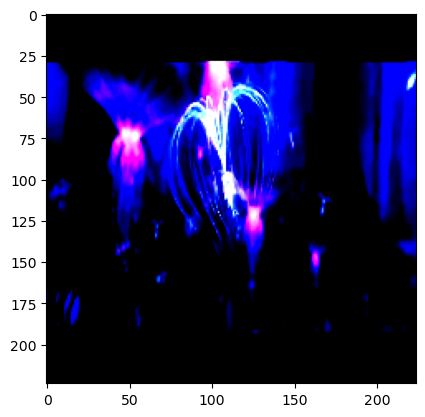

In [ ]:
plt.imshow(dataset[617].get('rgb').permute(1,2,3,0)[58])

# Модель


In [ ]:
backbone = r3d_18(weights="KINETICS400_V1")

In [ ]:
stage = 2

class RandomFrameClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # 1. Визуальная ветка (теперь сохраняет временную ось)
        self.visual_backbone = nn.Sequential(
           *list(backbone.children())[:-2],
        nn.AdaptiveAvgPool3d((None, 1, 1)),
        nn.Flatten(start_dim=2)
    )
        self.frame_projection = nn.Linear(512, 512)

        # Замораживаем все слои, кроме последнего
        for param in self.visual_backbone.parameters():
            param.requires_grad = False

        # 2. MultiheadAttention для 60 кадров
        self.frame_attention = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            dropout=0.1,
            batch_first=True  # Используем [B, T, D] формат
        )
        self.layer_norm = nn.LayerNorm(512)

        # 3. Аудио ветка (без изменений)
        self.audio_backbone = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        for param in self.audio_backbone.parameters():
            param.requires_grad = False

        self.audio_projection = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU()
        )

        # 4. Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512, 512),  # Объединяем видео и аудио
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, video_frames, audio):
        B, C, T, H, W = video_frames.shape

      # 1. Извлекаем фичи для каждого кадра
        video_features = self.visual_backbone(video_frames)  # [B, 512, T]
        video_features = video_features.permute(0, 2, 1)  # [B, T, 512]
        video_features = self.frame_projection(video_features)  # [B, 60, 512]

      # 2. Attention между кадрами
        attn_output, _ = self.frame_attention(
            video_features,  # [B, 60, 512]
            video_features,
            video_features
        )
        visual_features = self.layer_norm(attn_output.mean(dim=1))  # [B, 512]

        # 3. Аудио фичи
        audio_features = self.audio_backbone(audio).last_hidden_state
        audio_features = audio_features.mean(dim=1)
        audio_features = self.audio_projection(audio_features)  # [B, 512]

      # 4. Классификация
        combined = torch.cat([visual_features, audio_features], dim=1)
        return self.classifier(combined)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RandomFrameClassifier(num_classes=4).to(device)

# 2. Гиперпараметры
config = {
    'batch_size': 4,
    'num_epochs': 15,
    'learning_rate': 3e-4,
    'warmup_epochs': 2,
    'num_workers': 4,
    'gradient_clip': 1.0
}

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 3. Оптимизатор и планировщик

optimizer = AdamW([

    {'params': model.visual_backbone[0].parameters(), 'lr': 1e-6},  # Frozen CNN части
    {'params': model.visual_backbone[-1].parameters(), 'lr': 1e-5},  # Последний линейный слой


    {'params': model.frame_attention.parameters(), 'lr': 3e-5},
    {'params': model.frame_projection.parameters(), 'lr': 3e-5},


    {'params': model.audio_backbone.parameters(), 'lr': 1e-6},  # Frozen wav2vec
    {'params': model.audio_projection.parameters(), 'lr': 1e-5},  # Проекция аудио


    {'params': model.classifier.parameters(), 'lr': 5e-4}
], weight_decay=0.01)

total_steps = len(train_loader) * config['num_epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) * config['warmup_epochs'],
    num_training_steps=total_steps
)
criterion = CrossEntropyLoss()

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # График лосса
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # График точности
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        rgb = batch['rgb'].to(device)
        audio = batch['audio'].to(device)
        labels = batch['views'].squeeze(1).long().to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(rgb, audio)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })

    return total_loss / len(dataloader), correct / total

In [ ]:
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            rgb = batch['rgb'].to(device)
            audio = batch['audio'].to(device)
            labels = batch['views'].squeeze(1).long().to(device)

            outputs = model(rgb, audio)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total

## Сохранение чекпойнтов

In [ ]:
# Сохраняем модель после каждой эпохи и оцениваем метрики
def save_checkpoint_and_evaluate(model, val_loader, device, class_names, epoch):
    # Сохранение состояния модели
    checkpoint_path = f'checkpoint_epoch_{epoch}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'class_names': class_names
    }, checkpoint_path)
    print(f"✅ Модель сохранена в {checkpoint_path}")

    # Оценка качества классификации
    evaluate_classification(model, val_loader, device, class_names)


In [ ]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_path, device='cuda'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint and scheduler:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    class_names = checkpoint.get('class_names', {})
    print(f"✅ Чекпоинт загружен: {checkpoint_path} (начать с эпохи {start_epoch})")
    return model, optimizer, scheduler, start_epoch, class_names

In [ ]:
# === Загрузка модели и весов с чекпойнта 6-й эпохи (без оптимизатора) ===
checkpoint = torch.load("checkpoint_epoch_6.pth", map_location=device)

# Создание модели с той же архитектурой
model = RandomFrameClassifier(num_classes=4).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# Инициализация нового оптимизатора и lr scheduler
lr_map = {1: 1e-4, 2: 1e-5, 3: 5e-6}
optimizer = torch.optim.Adam(model.parameters(), lr=lr_map[stage], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Продолжение обучения с 7-й эпохи
start_epoch = checkpoint['epoch'] + 1
print(f"Checkpoint loaded (weights only). Resuming training from epoch {start_epoch}")

C:\Users\litvi\AppData\Local\Temp\ipykernel_21284\3127757134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_epoch_6.pth", map_locati

Checkpoint loaded (weights only). Resuming training from epoch 7


## Цикл обучения

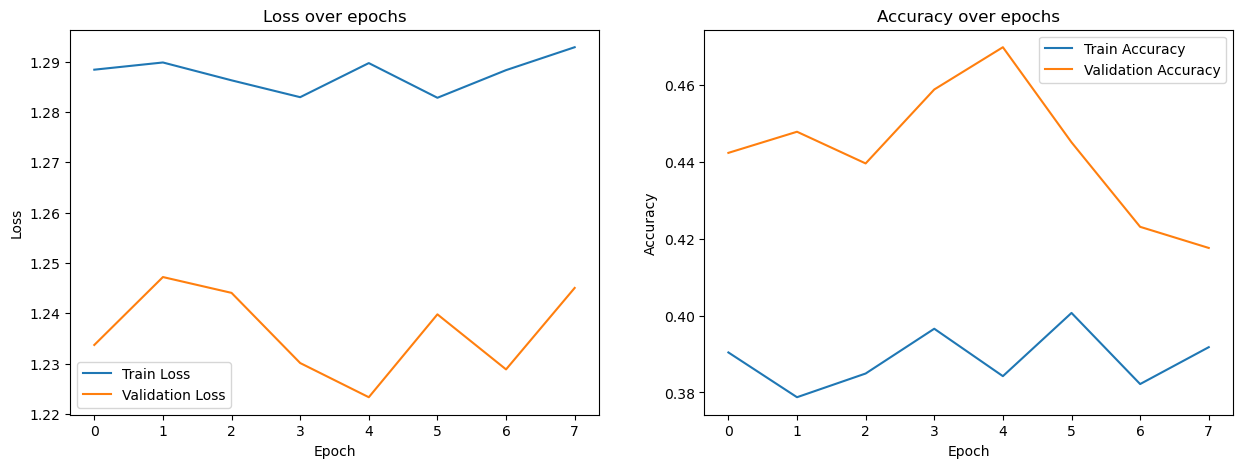


Сохранение финального состояния...
Финальная модель сохранена в 'final_model.pth'


In [ ]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

best_val_acc = 0

class_names = {
    0: "меньше 100 тысяч",
    1: "от 100 до 500 тысяч",
    2: "от 500 до 1М",
    3: ">1М"
}

# Путь для сохранения чекпоинтов

try:
    for epoch in range(start_epoch, config['num_epochs']):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")

        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Валидация
        val_loss, val_acc = validate(model, val_loader, device)
        scheduler.step(val_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_loss_history': train_loss_history,
                'val_loss_history': val_loss_history,
                'train_acc_history': train_acc_history,
                'val_acc_history': val_acc_history,
                'best_val_acc': best_val_acc,
                'class_names': class_names,
                'training_date': datetime.now().strftime("%Y-%m-%d")
            }, 'best_model.pth')
            print(f"Новая лучшая модель сохранена (Val Acc: {best_val_acc:.4f})")

        # Вывод метрик
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        # Отрисовка графиков
        save_checkpoint_and_evaluate(model, val_loader, device, class_names, epoch)
        plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

except (KeyboardInterrupt, Exception) as e:
    print(f"\nПрерывание! Экстренное завершение... Ошибка: {e}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'best_val_acc': best_val_acc,
        'class_names': class_names,
        'training_date': datetime.now().strftime("%Y-%m-%d")
    }, 'emergency_model.pth')
    raise

finally:
    print("\nСохранение финального состояния...")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'best_val_acc': best_val_acc,
        'class_names': class_names,
        'training_date': datetime.now().strftime("%Y-%m-%d")
    }, 'final_model.pth')
    print("Финальная модель сохранена в 'final_model.pth'")

In [ ]:
checkpoint = torch.load("best_model.pth", map_location="cpu")
val_acc_history = checkpoint.get("val_acc_history", [])

for i, acc in enumerate(val_acc_history):
    print(f"Эпоха {i+1}: val_acc = {acc:.4f}")

Эпоха 1: val_acc = 0.4423
Эпоха 2: val_acc = 0.4478
Эпоха 3: val_acc = 0.4396
Эпоха 4: val_acc = 0.4588
Эпоха 5: val_acc = 0.4698


C:\Users\litvi\AppData\Local\Temp\ipykernel_21284\3824524208.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location="cpu"

In [ ]:
best_epoch = checkpoint.get("epoch", None)
best_val_acc = checkpoint.get("best_val_acc", None)

print(f"✅ Лучшая модель была на эпохе: {best_epoch + 1}")
print(f"🎯 Validation Accuracy на ней: {best_val_acc:.4f}")

C:\Users\litvi\AppData\Local\Temp\ipykernel_21284\3166534233.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location="cpu"

✅ Лучшая модель была на эпохе: 12
🎯 Validation Accuracy на ней: 0.4698
